In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import selectivesearch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from pathlib import Path
from torch_snippets import *
from torchsummary import summary
from torch_snippets import Report
from torchvision.ops import batched_nms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from IPython.display import Image as DisplayImage, display

In [2]:
# Let's get our directory straight
current_dir = os.getcwd()
data_path   = os.path.join(current_dir, 'data')
train_data  = os.path.join(data_path,'training_images')
test_data   = os.path.join(data_path, 'testing_images')
df_cars     = pd.read_csv(os.path.join(data_path,'train_solution_bounding_boxes (1).csv'))

In [3]:
df_cars

image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

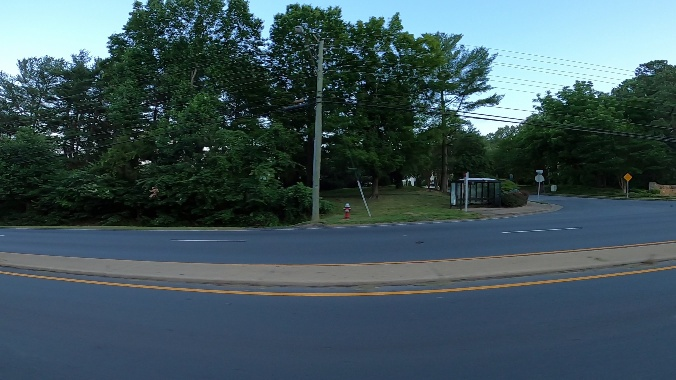

In [4]:
# Let's manually display an image here
img_manual_display = os.path.join(train_data, os.listdir(train_data)[17])
display(DisplayImage(filename = img_manual_display))

### Since there is no easy way of indexing images for selection I am aware of, I will create a class to have all the different paths as well as ensuring we are converting images from BGR to RGB 

In [5]:
class OpenImages(Dataset):
    def __init__(self, df, image_dir = train_data, transform = None):
        self.root = train_data
        self.df = df 
        self.transfrom = transform
        self.unique_images = df_cars['image'].unique()
        self.image_paths = {img_id: f'{self.root}/{img_id}' for img_id in self.unique_images}


    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, idx):
        img_id = self.unique_images[idx]
        image_path = self.image_paths[img_id]

        # Let's make sure the image is RGB 
        image = cv2.imread(image_path,1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        df_filtered = self.df[self.df['image'] == img_id]
        boxes = df_filtered[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.int32)
                                                                            
        return image, boxes, img_id

Now, we can define some a couple of functions, one to limit the aspect ratio of areas and another one to leverage the selectivesearch package and method to identify regions where there is a substantial change in pixel coloration within each of our images.

In [6]:
def filter_candidates_by_aspect_ratio(candidates, aspect_ratio_range=(0.3, 3.0)):
    filtered_candidates = []
    for x, y, w, h in candidates:
        aspect_ratio = w / float(h) if h > 0 else 0
        if aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
            filtered_candidates.append([x, y, w, h])
    return filtered_candidates


def selective_search_on_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, regions = selectivesearch.selective_search(image_rgb, scale=500, min_size=10)
    return regions

In [7]:
# We can adjust the number of images displayed by adjusting the batch_size in DataLoader
def imgshow(img, text=None):
    npimg = img.numpy()
    plt.figure(figsize=(10,6))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    if text is not None:
        plt.text(75,8, text,style= 'italic', frontweight='bold',\
                bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad':10
                        })
    plt.show()

c:\Users\18126\miniconda3\envs\Torchcv\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


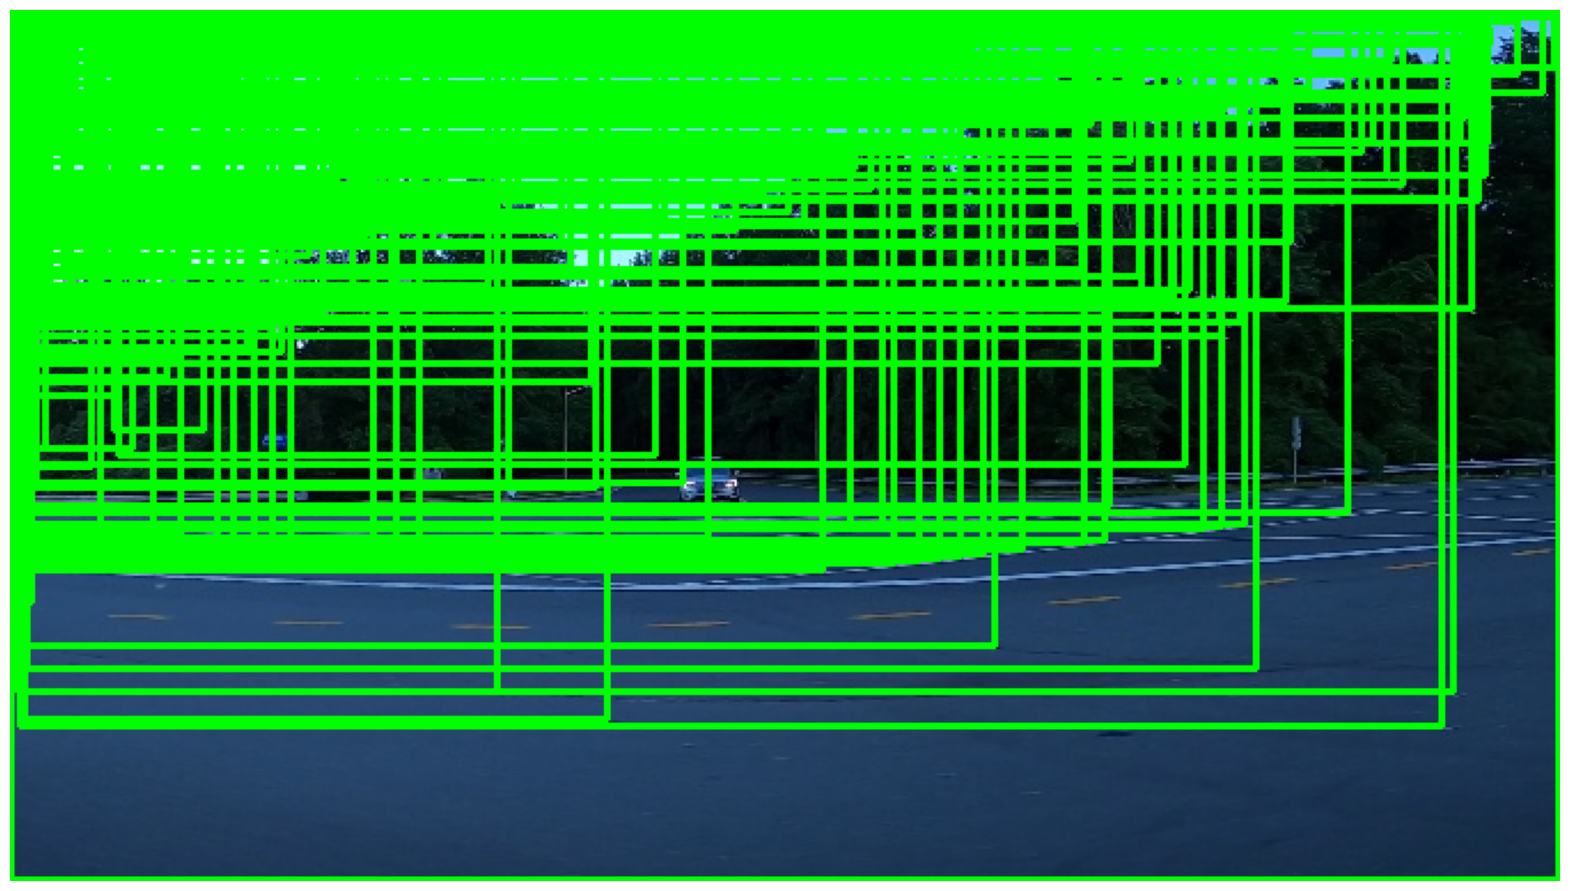

In [8]:
# Example usage
image_path = os.path.join(train_data, os.listdir(train_data)[0]) # This is how we can the image selection
regions = selective_search_on_image(image_path)

# Let's convert regions to a format suitable for filtering 
candidates = [r['rect'] for r in regions]

# Filter the regions based on the aspect ratio from our function
aspect_ratio_filtered_candidates = filter_candidates_by_aspect_ratio(candidates=candidates)

# Display the image with region proposals
image = read(image_path, 1)
show(image, bbs=aspect_ratio_filtered_candidates)

The previous code does not look very pretty.But trust me, it can be worse without our filter by aspect ratio function. Luckily, we have informationas to where each the recctangle should be drawn for each of image in our df dataframe. (Figuring this out took me about 4 hours) Now I know that I shouldn't try building everything from scratch hehe.

In [9]:
def draw_boxes(image,boxes):        
    for box in boxes: 
        xmin,ymin,xmax,ymax = box
        xmin,ymin,xmax,ymax = map(int,[xmin,ymin,xmax,ymax])
        cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(0,255,0),2) 
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

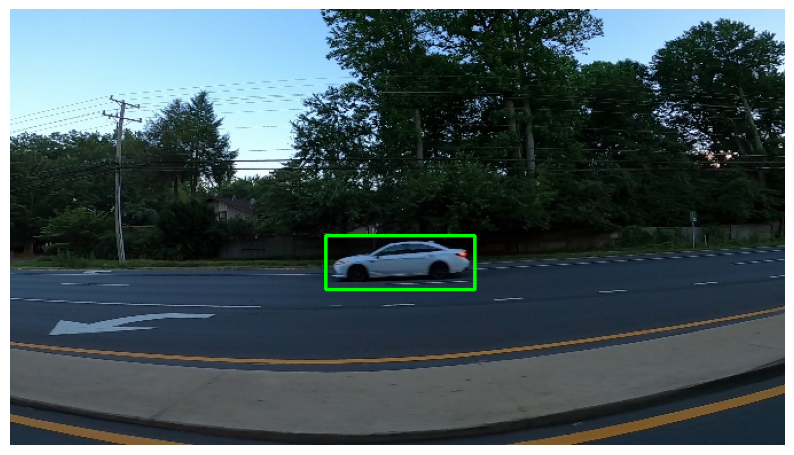

In [10]:
dataset = OpenImages(df_cars, train_data)

image_test1, boxes_test1, img_id = dataset[19] # We can change this value to get the different images
draw_boxes(image= image_test1,boxes=boxes_test1)

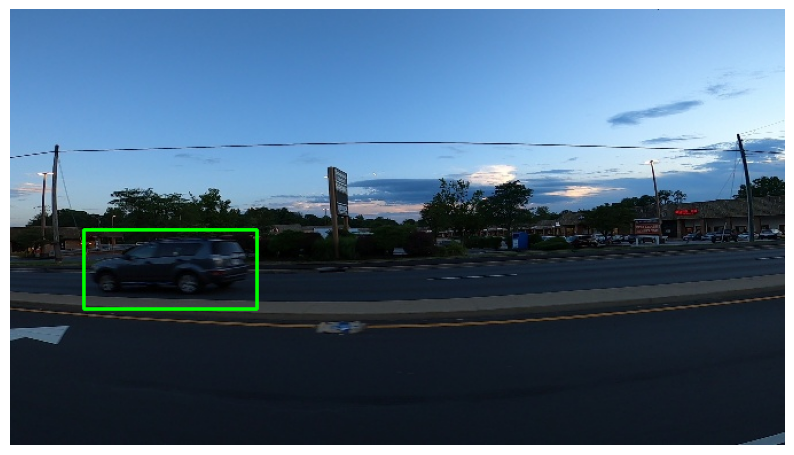

In [11]:
# Let's see another one with slightly different context
image_test1, boxes_test1, img_id = dataset[99] 
draw_boxes(image= image_test1,boxes=boxes_test1)

### Let's Build a Model That we can test against the test dataset

In [12]:
class VehicleDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.dataframe = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = self.image_dir / row.image
        image = cv2.imread(str(image_path)) / 255.0
        image = image.transpose((2, 0, 1))  # Convert to PyTorch format: CxHxW
        bbox_coords = np.array([row.xmin, row.ymin, row.xmax, row.ymax], dtype=np.float32)
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(bbox_coords, dtype=torch.float)

In [13]:
class VehicleModel(nn.Module):
    def __init__(self):
        super(VehicleModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(8), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
            # We can add more layers here if needed
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 95 * 169, 256), nn.ReLU(), # Dividing our dimentions (380*676) by four
            nn.Linear(256, 32), nn.ReLU(),
            nn.Linear(32, 4)                          # Return 4 dimensions, for the bounding box location
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

### We can start training our model now

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VehicleModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader
train_dataset = VehicleDataset(df_cars, Path(train_data))
train_loader  = DataLoader(train_dataset, batch_size= 16, shuffle=True)

In [15]:
# Training loop
print(f'Model structure:', model)
total_params = sum(p.numel() for p in model.parameters())

print("Total number of parameters is: ", total_params)
print("Total number of trainable parameters is: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Since we are using a single learning rate for all parameter groups
current_lr = optimizer.param_groups[0]['lr']
print(f'Current learning rate: {current_lr}')

for epoch in range(20):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss/len(train_loader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}, Loss: {avg_loss},Current learning rate: {current_lr}')

Model structure: VehicleModel(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256880, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=4, bias=True)
  )
)

Total number of parameters is:  65771332

Total number of trainable parameters is:  65771332

Current learning rate: 0.001

Epoch 1, Loss: 29650.440457589284,Current learning rate: 0.001

Epoch 2, Loss: 20290.2166015625,Current learning rate: 0.001

Epoch 3, Loss: 17409.177371651786,Current learning rate: 0.001

Epoch 4, Loss: 15819.695563616071,Current learning rate: 0.001

Epoch 5, Loss: 14167.498744419643,Current learning rate: 0.001

Epoch 6, Loss: 13989.579255022321,Current learning rate: 0.001

Epoch 7, Loss: 13017.333454241072,Current learning rate: 0.001

Epoch 8, Loss: 11989.432854352679,Current learning rate: 0.001

Epoch 9, Loss: 11749.326353236607,Current learning rate: 0.001

Epoch 10, Loss: 11804.396330915179,Current learning rate: 0.001

Epoch 11, Loss: 11482.77232142857,Current learning rate: 0.001

Epoch 12, Loss: 11152.525090680803,Current learning rate: 0.001

Epoch 13, Loss: 11081.413741629463,Current learning rate: 0.001

Epoch 14, Loss: 10927.092047991071,Current learning rate: 0.001

Epoch 15, Loss: 10920.210972377232,Current learning rate: 0.001

Epoch 16, Loss: 11286.676681082588,Current learning rate: 0.001

Epoch 17, Loss: 11348.624176897321,Current learning rate: 0.001

Epoch 18, Loss: 11127.382798549108,Current learning rate: 0.001

Epoch 19, Loss: 11050.635728236608,Current learning rate: 0.001

Epoch 20, Loss: 11158.34388950893,Current learning rate: 0.001

In [16]:
summary(model, input_size=(3, 380, 676))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 380, 676]             224
              ReLU-2          [-1, 8, 380, 676]               0
       BatchNorm2d-3          [-1, 8, 380, 676]              16
         MaxPool2d-4          [-1, 8, 190, 338]               0
            Conv2d-5         [-1, 16, 190, 338]           1,168
              ReLU-6         [-1, 16, 190, 338]               0
       BatchNorm2d-7         [-1, 16, 190, 338]              32
         MaxPool2d-8          [-1, 16, 95, 169]               0
           Flatten-9               [-1, 256880]               0
           Linear-10                  [-1, 256]      65,761,536
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 32]           8,224
             ReLU-13                   [-1, 32]               0
           Linear-14                   

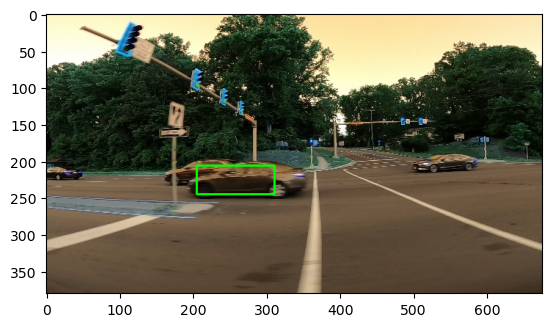

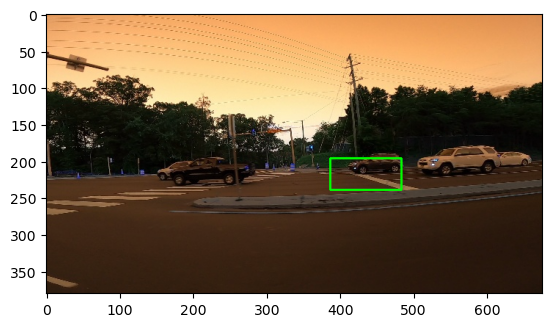

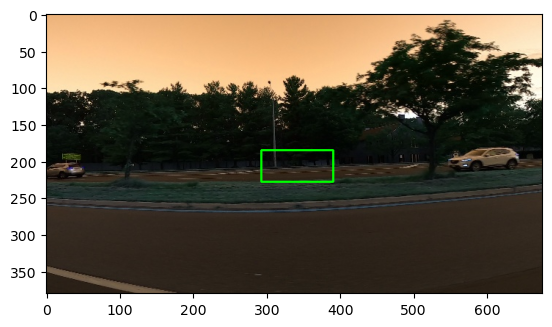

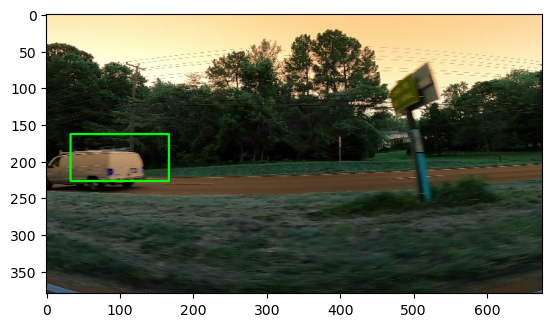

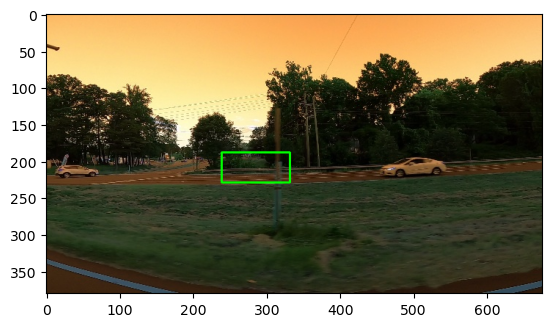

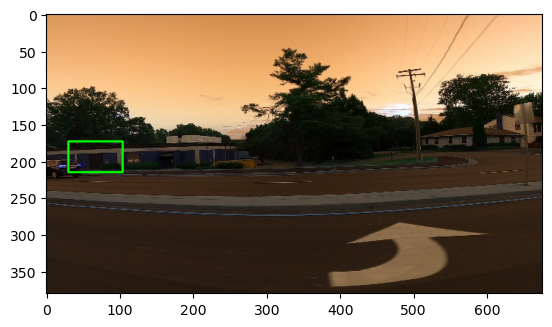

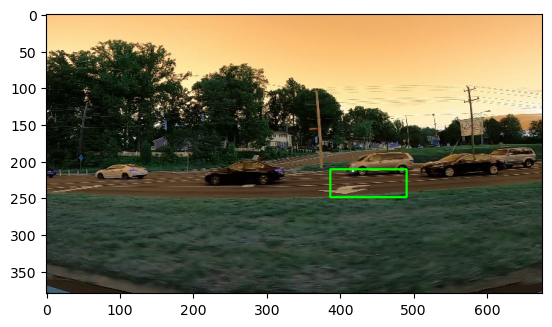

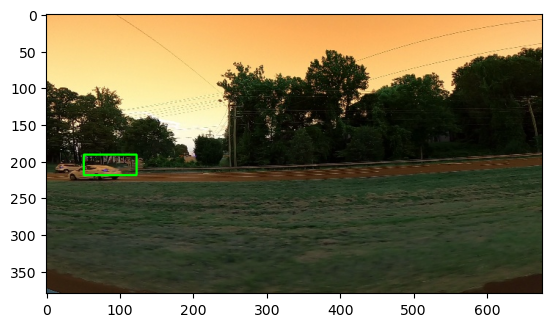

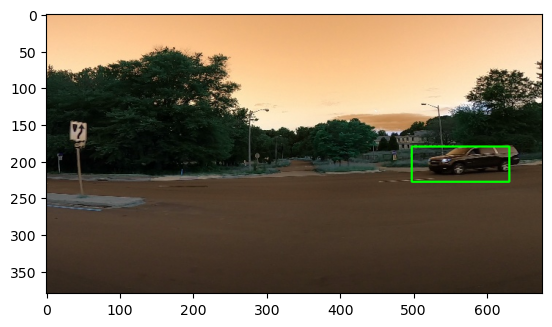

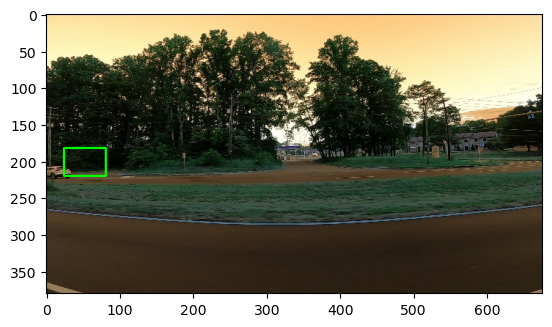

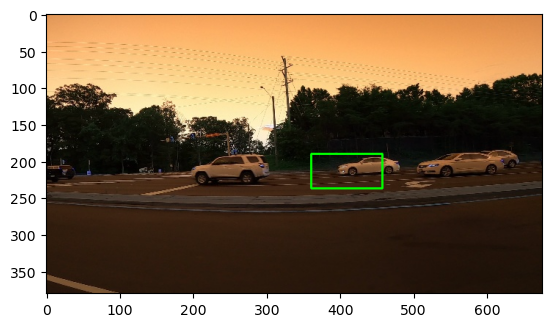

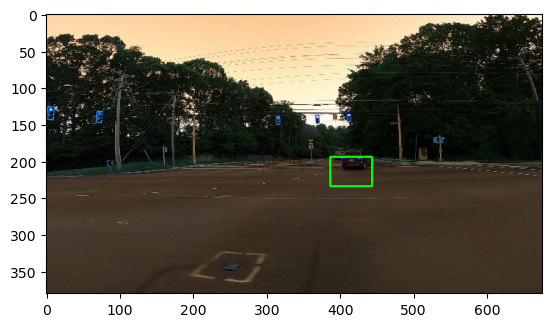

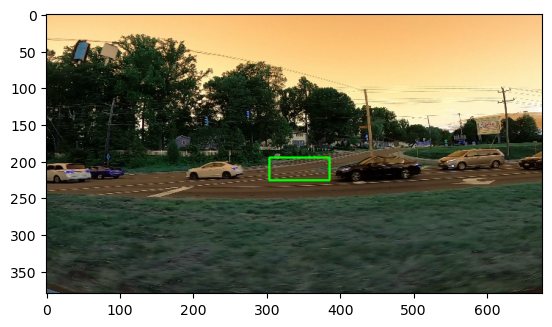

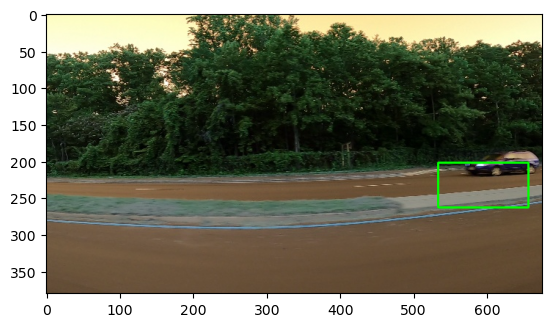

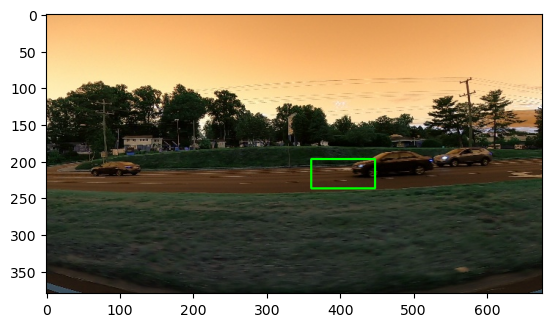

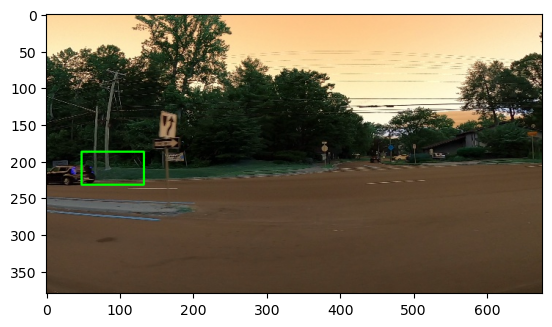

In [22]:
def display_image(img, bbox_coords, norm=False):
    if norm:
        img = img * 255
    img = img.astype(np.uint8).copy()
    # Convert bbox_coords back if it was normalized
    cv2.rectangle(img, (int(bbox_coords[0]), int(bbox_coords[1])), (int(bbox_coords[2]), int(bbox_coords[3])), (0,255,0), 2)
    plt.imshow(img)
    plt.show()

# Example usage after training for testing on a single batch
inputs, targets = next(iter(train_loader))
predicted = model(inputs.to(device))
for i in range(inputs.size(0)):
    display_image(inputs[i].cpu().numpy().transpose(1, 2, 0), predicted[i].cpu().detach().numpy(), norm=True)

In [ ]:
# Let's save our model now
model.save('Car_Object_Detection.h5')

## Conclusion
In this notebook, we were able to not only able to draw a boundary box around vehicles in our training data pictures, but also build a model we were able to test against our test dataset. This notebook touches upon some introductory concepts of object detectino in python. In the next ipynb file, we will be able to leverage some pretrain models to have even higher accuracy and complexify some concepts in object detection. Stay tuned & happy coding everyone!